* **Name :** Ruchit Vithani
* **ID ::** 201701070
* **Lab 9: Experiment on GAN**
* **Date :** 12-11-2020 (mm-dd-yy)

# **Importing libraries**

In [78]:
import tensorflow as tf
import numpy as np

from tensorflow.keras.layers import Dense, Conv2D, Reshape, BatchNormalization, Activation, MaxPool2D, Dropout, LeakyReLU, Flatten, Conv2DTranspose, UpSampling2D
from tensorflow.keras.models import Sequential
from keras.datasets.mnist import load_data
import matplotlib.pyplot as plt
from tqdm import tqdm

# **Task 1:**

## **Load dataset**

In [61]:
(train_images, _), (_, _) = tf.keras.datasets.mnist.load_data() 

train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
train_images = (train_images - 127.5) / 127.5 # Normalize the images to [-1, 1]

BUFFER_SIZE = 60000
BATCH_SIZE = 256
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

## **Make generator model**

* A convolutional model that inputs a vector of size $(100,)$ as input. The model consists of : (1) First obtaining the feature maps of size $(7, 7, 256)$ from the noisy latent vector. (2) Followed by this, use successive transposed convolutional layer to obtain image of size $(28, 28, 1)$

In [3]:
def make_generator_model():
    model = Sequential()
    model.add(Dense(7*7*256, use_bias=False, input_shape=(100,)))
    model.add(BatchNormalization())
    model.add(LeakyReLU())
    model.add(Reshape((7, 7, 256)))

    model.add(Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    model.add(BatchNormalization())
    model.add(LeakyReLU())
    model.add(Conv2D(256, (3, 3), strides=(1, 1), padding='same', use_bias=False))
    model.add(BatchNormalization())
    model.add(LeakyReLU())

    model.add(Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(BatchNormalization())
    model.add(LeakyReLU())
    model.add(Conv2D(128, (3, 3), strides=(1, 1), padding='same', use_bias=False))
    model.add(BatchNormalization())
    model.add(LeakyReLU())


    model.add(Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    return model

In [4]:
generator = make_generator_model()

## **Visualising generated image by generator (non trained)**

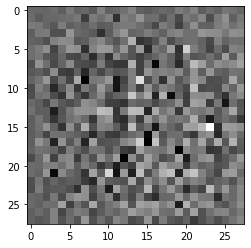

In [5]:
noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)
plt.figure()
plt.imshow(generated_image[0, :, :, 0], cmap='gray')
plt.show()

## **Define Discriminator model**

In [6]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    
    model.add(Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[28, 28, 1]))
    model.add(LeakyReLU())
    model.add(Dropout(0.3))

    model.add(Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(LeakyReLU())
    model.add(Dropout(0.3))

    model.add(Flatten())
    model.add(Dense(1))

    return model

In [7]:
discriminator = make_discriminator_model()

In [8]:
decision = discriminator(generated_image)
print (decision)

tf.Tensor([[-0.00021879]], shape=(1, 1), dtype=float32)


## **Define generator and discriminator losses**

* Generator : Objective is to generate image such that discriminator classifies it as label 1 image. 

* Discriminator : Objective is to correctly identify the original images, and generated images. Original label = 1, generated label = 0

In [9]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)
def discriminator_loss(real_out, fake_out):
    real_loss = cross_entropy(tf.ones_like(real_out), real_out)
    fake_loss = cross_entropy(tf.zeros_like(fake_out), fake_out)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_out):
    return cross_entropy(tf.ones_like(fake_out), fake_out)

generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

## **Configurations and Helper functions**

In [11]:
EPOCHS = 300
EPOCHS_INIT = 5
num_examples_to_generate = 30
noise_dim = 100
seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [12]:
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)

        real_out = discriminator(images, training=True)
        fake_out = discriminator(generated_images, training=True)

        gen_loss = generator_loss(fake_out)
        disc_loss = discriminator_loss(real_out, fake_out)

    gradients_of_generator = gen_tape.gradient(gen_loss, 
                                                generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, 
                                                discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return real_out, fake_out, gen_loss, disc_loss

bin_accuracy = tf.keras.metrics.BinaryAccuracy()
def cal_accuracy(real_out, fake_out):
    labels_1 = tf.ones_like(real_out)
    labels_0 = tf.zeros_like(fake_out)

    y_pred = tf.concat((real_out, fake_out), axis=0)
    y_true = tf.concat((labels_1, labels_0), axis=0)

    accuracy = bin_accuracy(y_true, y_pred)

    return accuracy

def generate_and_save_images(model, epoch, test_input):
 
  predictions = model(test_input, training=False)
  fig = plt.figure(figsize=(20,7))
  for i in range(predictions.shape[0]):
      plt.subplot(3, 10, i+1)
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray', aspect='auto')
      plt.axis('off')
  # 3 - Save the generated images
  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()


## **Model summaries**

In [13]:
print("\n\n Generator Summary : ")
generator.summary()

print("\n\n Discriminator Summary : ")
discriminator.summary()



 Generator Summary : 
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 12544)             1254400   
_________________________________________________________________
batch_normalization (BatchNo (None, 12544)             50176     
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 12544)             0         
_________________________________________________________________
reshape (Reshape)            (None, 7, 7, 256)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 7, 7, 128)         819200    
_________________________________________________________________
batch_normalization_1 (Batch (None, 7, 7, 128)         512       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (No

## **Training loop**

Initialising D by first training it on images for 5 epochs : 



[5/5]    d_loss : 0.000126: 100%|██████████| 235/235 [00:18<00:00, 12.45it/s]




Printing generated images before any training 



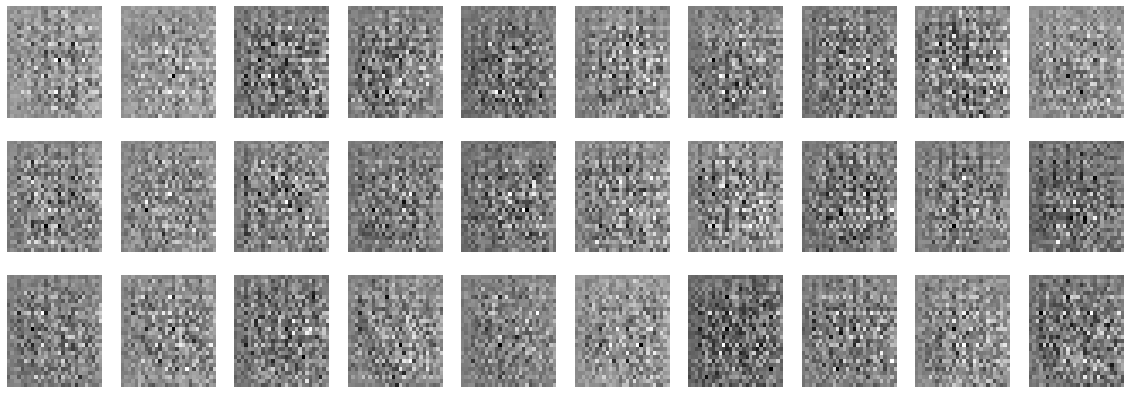



Start GAN Training : 



[1/300]	Loss_D = 0.001615	Loss_G = 0.010322	Accuracy = 0.929459	: 100%|██████████| 235/235 [00:21<00:00, 11.17it/s]
[2/300]	Loss_D = 0.003511	Loss_G = 0.006218	Accuracy = 0.868105	: 100%|██████████| 235/235 [00:19<00:00, 12.34it/s]
[3/300]	Loss_D = 0.004000	Loss_G = 0.006186	Accuracy = 0.846978	: 100%|██████████| 235/235 [00:18<00:00, 12.43it/s]
[4/300]	Loss_D = 0.005202	Loss_G = 0.003990	Accuracy = 0.825790	: 100%|██████████| 235/235 [00:18<00:00, 12.48it/s]
[5/300]	Loss_D = 0.004766	Loss_G = 0.004024	Accuracy = 0.807839	: 100%|██████████| 235/235 [00:18<00:00, 12.44it/s]
[6/300]	Loss_D = 0.005441	Loss_G = 0.003560	Accuracy = 0.792802	: 100%|██████████| 235/235 [00:18<00:00, 12.45it/s]
[7/300]	Loss_D = 0.004919	Loss_G = 0.003574	Accuracy = 0.779780	: 100%|██████████| 235/235 [00:18<00:00, 12.44it/s]
[8/300]	Loss_D = 0.004903	Loss_G = 0.003727	Accuracy = 0.768966	: 100%|██████████| 235/235 [00:18<00:00, 12.43it/s]
[9/300]	Loss_D = 0.005335	Loss_G = 0.003466	Accuracy = 0.759991	: 100%|█



Printing generated images after epoch  20 



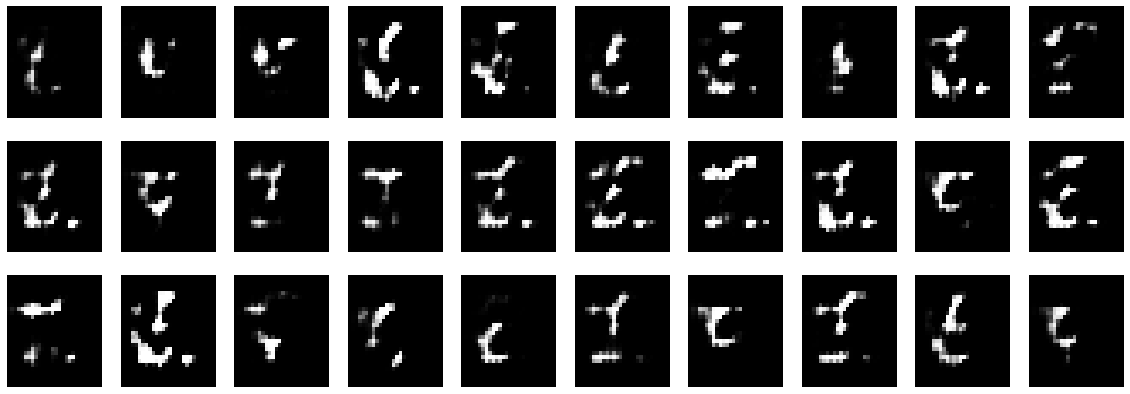

[21/300]	Loss_D = 0.004783	Loss_G = 0.003846	Accuracy = 0.709138	: 100%|██████████| 235/235 [00:19<00:00, 12.32it/s]
[22/300]	Loss_D = 0.004639	Loss_G = 0.003890	Accuracy = 0.707337	: 100%|██████████| 235/235 [00:19<00:00, 12.31it/s]
[23/300]	Loss_D = 0.004466	Loss_G = 0.004004	Accuracy = 0.705762	: 100%|██████████| 235/235 [00:19<00:00, 12.34it/s]
[24/300]	Loss_D = 0.004767	Loss_G = 0.003952	Accuracy = 0.704380	: 100%|██████████| 235/235 [00:19<00:00, 12.31it/s]
[25/300]	Loss_D = 0.004260	Loss_G = 0.004338	Accuracy = 0.703154	: 100%|██████████| 235/235 [00:19<00:00, 12.34it/s]
[26/300]	Loss_D = 0.004371	Loss_G = 0.004326	Accuracy = 0.702098	: 100%|██████████| 235/235 [00:19<00:00, 12.28it/s]
[27/300]	Loss_D = 0.004254	Loss_G = 0.004642	Accuracy = 0.701216	: 100%|██████████| 235/235 [00:19<00:00, 12.23it/s]
[28/300]	Loss_D = 0.004342	Loss_G = 0.004500	Accuracy = 0.700463	: 100%|██████████| 235/235 [00:19<00:00, 12.29it/s]
[29/300]	Loss_D = 0.004594	Loss_G = 0.004048	Accuracy = 0.699780



Printing generated images after epoch  40 



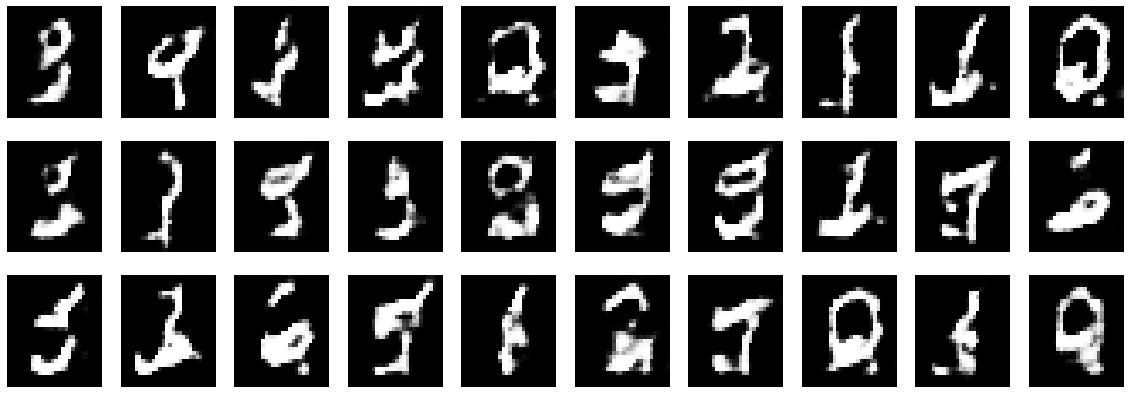

[41/300]	Loss_D = 0.004887	Loss_G = 0.003798	Accuracy = 0.694007	: 100%|██████████| 235/235 [00:19<00:00, 12.17it/s]
[42/300]	Loss_D = 0.004822	Loss_G = 0.003799	Accuracy = 0.693584	: 100%|██████████| 235/235 [00:19<00:00, 12.10it/s]
[43/300]	Loss_D = 0.005053	Loss_G = 0.003561	Accuracy = 0.693170	: 100%|██████████| 235/235 [00:19<00:00, 12.13it/s]
[44/300]	Loss_D = 0.005250	Loss_G = 0.003227	Accuracy = 0.692734	: 100%|██████████| 235/235 [00:19<00:00, 12.14it/s]
[45/300]	Loss_D = 0.005050	Loss_G = 0.003436	Accuracy = 0.692278	: 100%|██████████| 235/235 [00:19<00:00, 12.17it/s]
[46/300]	Loss_D = 0.004922	Loss_G = 0.003722	Accuracy = 0.691824	: 100%|██████████| 235/235 [00:19<00:00, 12.12it/s]
[47/300]	Loss_D = 0.004993	Loss_G = 0.003615	Accuracy = 0.691385	: 100%|██████████| 235/235 [00:19<00:00, 12.08it/s]
[48/300]	Loss_D = 0.005099	Loss_G = 0.003389	Accuracy = 0.690939	: 100%|██████████| 235/235 [00:19<00:00, 12.09it/s]
[49/300]	Loss_D = 0.005031	Loss_G = 0.003492	Accuracy = 0.690490



Printing generated images after epoch  60 



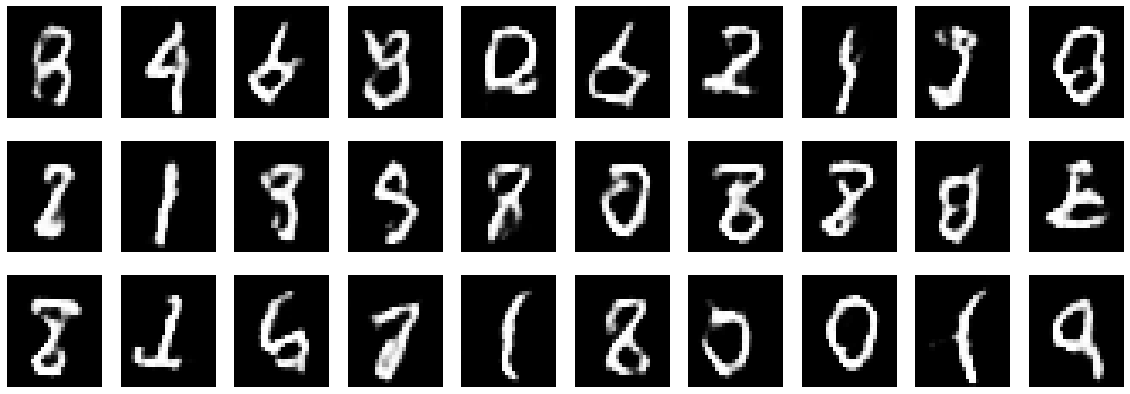

[61/300]	Loss_D = 0.005152	Loss_G = 0.003238	Accuracy = 0.684851	: 100%|██████████| 235/235 [00:19<00:00, 11.86it/s]
[62/300]	Loss_D = 0.005124	Loss_G = 0.003322	Accuracy = 0.684374	: 100%|██████████| 235/235 [00:19<00:00, 11.85it/s]
[63/300]	Loss_D = 0.005182	Loss_G = 0.003224	Accuracy = 0.683898	: 100%|██████████| 235/235 [00:19<00:00, 11.97it/s]
[64/300]	Loss_D = 0.005203	Loss_G = 0.003185	Accuracy = 0.683425	: 100%|██████████| 235/235 [00:19<00:00, 11.97it/s]
[65/300]	Loss_D = 0.005154	Loss_G = 0.003247	Accuracy = 0.682951	: 100%|██████████| 235/235 [00:19<00:00, 12.11it/s]
[66/300]	Loss_D = 0.005005	Loss_G = 0.003449	Accuracy = 0.682487	: 100%|██████████| 235/235 [00:19<00:00, 11.95it/s]
[67/300]	Loss_D = 0.005043	Loss_G = 0.003390	Accuracy = 0.682029	: 100%|██████████| 235/235 [00:19<00:00, 11.91it/s]
[68/300]	Loss_D = 0.005084	Loss_G = 0.003457	Accuracy = 0.681578	: 100%|██████████| 235/235 [00:19<00:00, 11.92it/s]
[69/300]	Loss_D = 0.005198	Loss_G = 0.003246	Accuracy = 0.681131



Printing generated images after epoch  80 



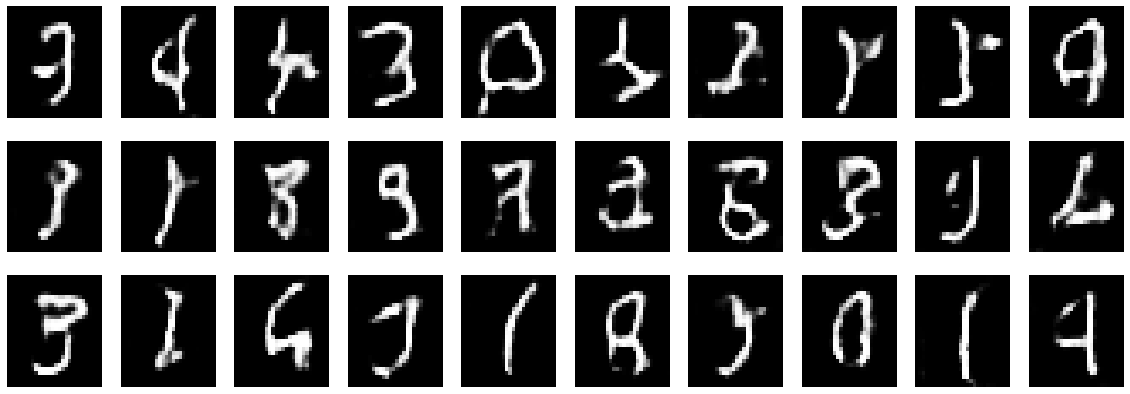

[81/300]	Loss_D = 0.005202	Loss_G = 0.003257	Accuracy = 0.676123	: 100%|██████████| 235/235 [00:19<00:00, 11.84it/s]
[82/300]	Loss_D = 0.004942	Loss_G = 0.003605	Accuracy = 0.675738	: 100%|██████████| 235/235 [00:19<00:00, 11.82it/s]
[83/300]	Loss_D = 0.005081	Loss_G = 0.003299	Accuracy = 0.675361	: 100%|██████████| 235/235 [00:19<00:00, 11.86it/s]
[84/300]	Loss_D = 0.005185	Loss_G = 0.003196	Accuracy = 0.674982	: 100%|██████████| 235/235 [00:19<00:00, 11.86it/s]
[85/300]	Loss_D = 0.005087	Loss_G = 0.003265	Accuracy = 0.674607	: 100%|██████████| 235/235 [00:19<00:00, 11.78it/s]
[86/300]	Loss_D = 0.005073	Loss_G = 0.003265	Accuracy = 0.674234	: 100%|██████████| 235/235 [00:19<00:00, 11.79it/s]
[87/300]	Loss_D = 0.005080	Loss_G = 0.003329	Accuracy = 0.673862	: 100%|██████████| 235/235 [00:19<00:00, 11.80it/s]
[88/300]	Loss_D = 0.005169	Loss_G = 0.003250	Accuracy = 0.673495	: 100%|██████████| 235/235 [00:19<00:00, 11.76it/s]
[89/300]	Loss_D = 0.005024	Loss_G = 0.003386	Accuracy = 0.673132



Printing generated images after epoch  100 



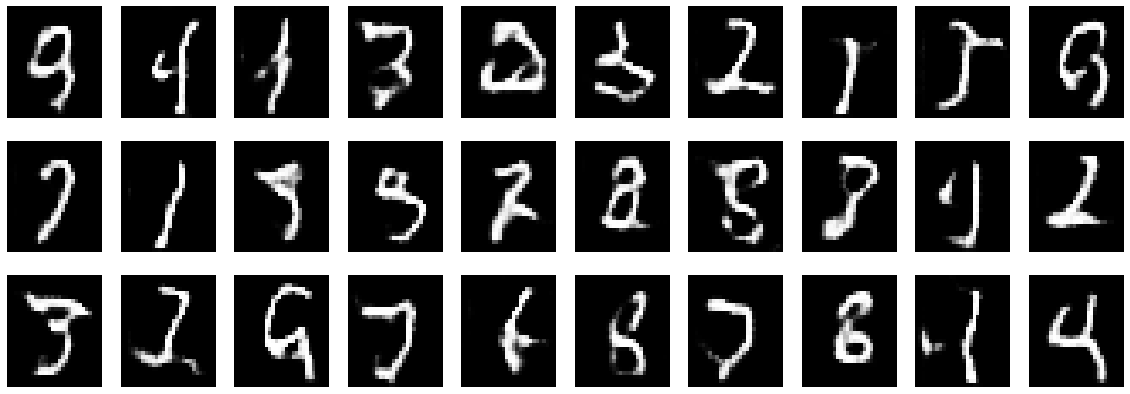

[101/300]	Loss_D = 0.005115	Loss_G = 0.003232	Accuracy = 0.669038	: 100%|██████████| 235/235 [00:20<00:00, 11.57it/s]
[102/300]	Loss_D = 0.005163	Loss_G = 0.003263	Accuracy = 0.668712	: 100%|██████████| 235/235 [00:20<00:00, 11.54it/s]
[103/300]	Loss_D = 0.005160	Loss_G = 0.003278	Accuracy = 0.668392	: 100%|██████████| 235/235 [00:20<00:00, 11.53it/s]
[104/300]	Loss_D = 0.005078	Loss_G = 0.003320	Accuracy = 0.668077	: 100%|██████████| 235/235 [00:20<00:00, 11.54it/s]
[105/300]	Loss_D = 0.005163	Loss_G = 0.003240	Accuracy = 0.667759	: 100%|██████████| 235/235 [00:20<00:00, 11.59it/s]
[106/300]	Loss_D = 0.005174	Loss_G = 0.003179	Accuracy = 0.667448	: 100%|██████████| 235/235 [00:20<00:00, 11.62it/s]
[107/300]	Loss_D = 0.005191	Loss_G = 0.003208	Accuracy = 0.667143	: 100%|██████████| 235/235 [00:20<00:00, 11.56it/s]
[108/300]	Loss_D = 0.005112	Loss_G = 0.003296	Accuracy = 0.666840	: 100%|██████████| 235/235 [00:20<00:00, 11.55it/s]
[109/300]	Loss_D = 0.005132	Loss_G = 0.003217	Accuracy =



Printing generated images after epoch  120 



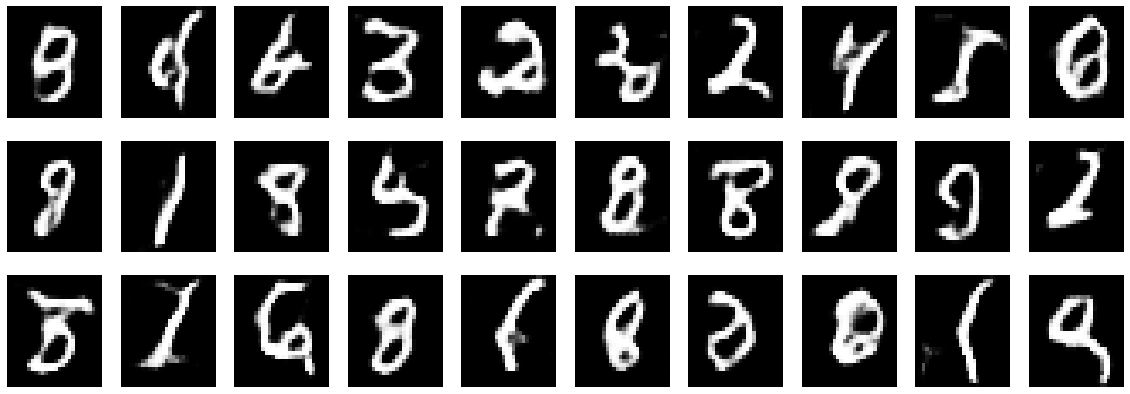

[121/300]	Loss_D = 0.005160	Loss_G = 0.003156	Accuracy = 0.663041	: 100%|██████████| 235/235 [00:20<00:00, 11.68it/s]
[122/300]	Loss_D = 0.005195	Loss_G = 0.003157	Accuracy = 0.662761	: 100%|██████████| 235/235 [00:20<00:00, 11.66it/s]
[123/300]	Loss_D = 0.005218	Loss_G = 0.003180	Accuracy = 0.662486	: 100%|██████████| 235/235 [00:20<00:00, 11.69it/s]
[124/300]	Loss_D = 0.005190	Loss_G = 0.003195	Accuracy = 0.662215	: 100%|██████████| 235/235 [00:20<00:00, 11.69it/s]
[125/300]	Loss_D = 0.005219	Loss_G = 0.003111	Accuracy = 0.661947	: 100%|██████████| 235/235 [00:20<00:00, 11.67it/s]
[126/300]	Loss_D = 0.005214	Loss_G = 0.003120	Accuracy = 0.661670	: 100%|██████████| 235/235 [00:20<00:00, 11.62it/s]
[127/300]	Loss_D = 0.005231	Loss_G = 0.003083	Accuracy = 0.661396	: 100%|██████████| 235/235 [00:20<00:00, 11.64it/s]
[128/300]	Loss_D = 0.005241	Loss_G = 0.003125	Accuracy = 0.661127	: 100%|██████████| 235/235 [00:20<00:00, 11.57it/s]
[129/300]	Loss_D = 0.005163	Loss_G = 0.003184	Accuracy =



Printing generated images after epoch  140 



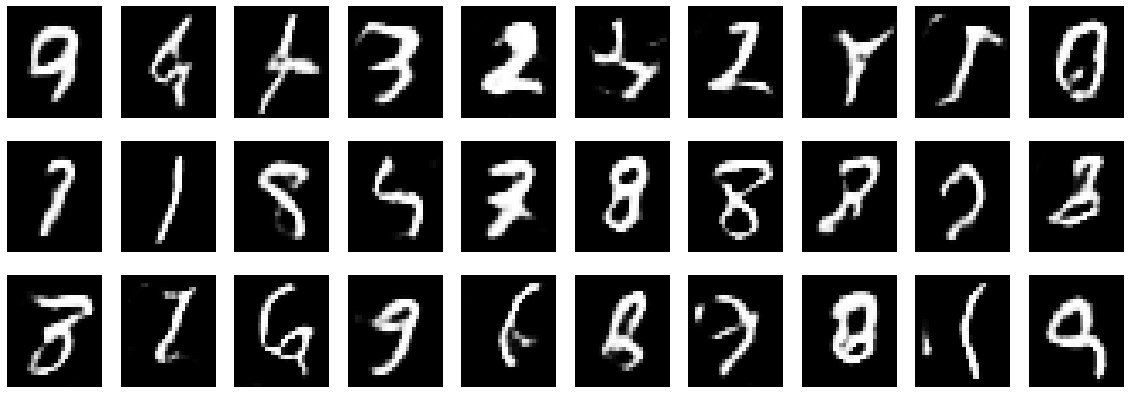

[141/300]	Loss_D = 0.005290	Loss_G = 0.002983	Accuracy = 0.657742	: 100%|██████████| 235/235 [00:20<00:00, 11.55it/s]
[142/300]	Loss_D = 0.005293	Loss_G = 0.002971	Accuracy = 0.657484	: 100%|██████████| 235/235 [00:20<00:00, 11.56it/s]
[143/300]	Loss_D = 0.005230	Loss_G = 0.003056	Accuracy = 0.657229	: 100%|██████████| 235/235 [00:20<00:00, 11.48it/s]
[144/300]	Loss_D = 0.005248	Loss_G = 0.003167	Accuracy = 0.656978	: 100%|██████████| 235/235 [00:20<00:00, 11.52it/s]
[145/300]	Loss_D = 0.005163	Loss_G = 0.003250	Accuracy = 0.656731	: 100%|██████████| 235/235 [00:20<00:00, 11.56it/s]
[146/300]	Loss_D = 0.005194	Loss_G = 0.003188	Accuracy = 0.656482	: 100%|██████████| 235/235 [00:20<00:00, 11.52it/s]
[147/300]	Loss_D = 0.005219	Loss_G = 0.003082	Accuracy = 0.656228	: 100%|██████████| 235/235 [00:20<00:00, 11.51it/s]
[148/300]	Loss_D = 0.005277	Loss_G = 0.003045	Accuracy = 0.655978	: 100%|██████████| 235/235 [00:20<00:00, 11.56it/s]
[149/300]	Loss_D = 0.005236	Loss_G = 0.003073	Accuracy =



Printing generated images after epoch  160 



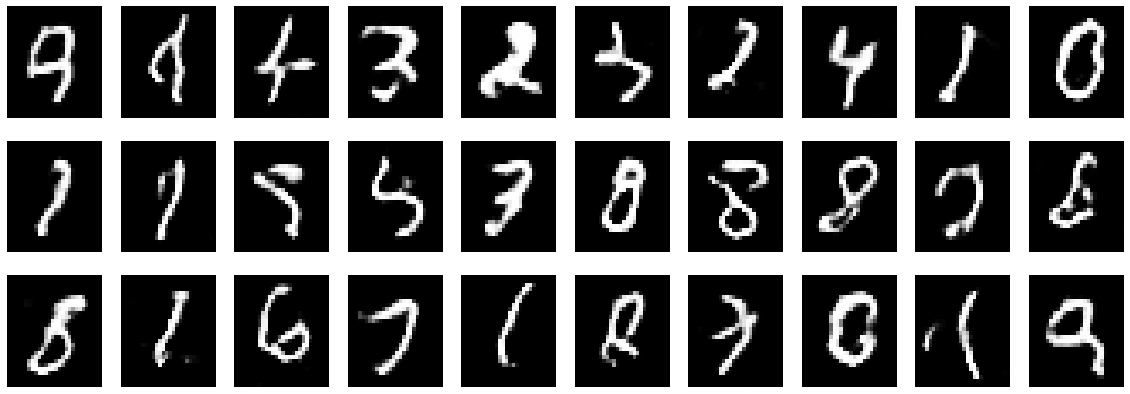

[161/300]	Loss_D = 0.005265	Loss_G = 0.003025	Accuracy = 0.652838	: 100%|██████████| 235/235 [00:20<00:00, 11.38it/s]
[162/300]	Loss_D = 0.005305	Loss_G = 0.003048	Accuracy = 0.652605	: 100%|██████████| 235/235 [00:20<00:00, 11.33it/s]
[163/300]	Loss_D = 0.005274	Loss_G = 0.003019	Accuracy = 0.652376	: 100%|██████████| 235/235 [00:20<00:00, 11.31it/s]
[164/300]	Loss_D = 0.005234	Loss_G = 0.003075	Accuracy = 0.652141	: 100%|██████████| 235/235 [00:20<00:00, 11.31it/s]
[165/300]	Loss_D = 0.005288	Loss_G = 0.003063	Accuracy = 0.651905	: 100%|██████████| 235/235 [00:20<00:00, 11.38it/s]
[166/300]	Loss_D = 0.005256	Loss_G = 0.003024	Accuracy = 0.651673	: 100%|██████████| 235/235 [00:20<00:00, 11.30it/s]
[167/300]	Loss_D = 0.005285	Loss_G = 0.003034	Accuracy = 0.651443	: 100%|██████████| 235/235 [00:20<00:00, 11.33it/s]
[168/300]	Loss_D = 0.005278	Loss_G = 0.003011	Accuracy = 0.651216	: 100%|██████████| 235/235 [00:20<00:00, 11.30it/s]
[169/300]	Loss_D = 0.005278	Loss_G = 0.002989	Accuracy =



Printing generated images after epoch  180 



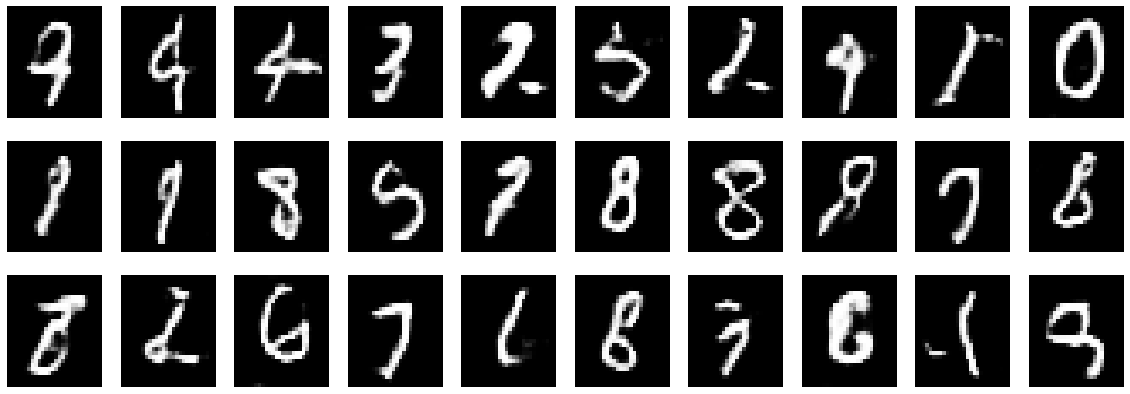

[181/300]	Loss_D = 0.005306	Loss_G = 0.003041	Accuracy = 0.648311	: 100%|██████████| 235/235 [00:20<00:00, 11.31it/s]
[182/300]	Loss_D = 0.005260	Loss_G = 0.003008	Accuracy = 0.648097	: 100%|██████████| 235/235 [00:20<00:00, 11.24it/s]
[183/300]	Loss_D = 0.005257	Loss_G = 0.003055	Accuracy = 0.647879	: 100%|██████████| 235/235 [00:20<00:00, 11.23it/s]
[184/300]	Loss_D = 0.005289	Loss_G = 0.003001	Accuracy = 0.647659	: 100%|██████████| 235/235 [00:20<00:00, 11.23it/s]
[185/300]	Loss_D = 0.005305	Loss_G = 0.002980	Accuracy = 0.647441	: 100%|██████████| 235/235 [00:20<00:00, 11.25it/s]
[186/300]	Loss_D = 0.005281	Loss_G = 0.002984	Accuracy = 0.647226	: 100%|██████████| 235/235 [00:20<00:00, 11.26it/s]
[187/300]	Loss_D = 0.005307	Loss_G = 0.002980	Accuracy = 0.647013	: 100%|██████████| 235/235 [00:20<00:00, 11.24it/s]
[188/300]	Loss_D = 0.005243	Loss_G = 0.003072	Accuracy = 0.646803	: 100%|██████████| 235/235 [00:21<00:00, 11.18it/s]
[189/300]	Loss_D = 0.005239	Loss_G = 0.003101	Accuracy =



Printing generated images after epoch  200 



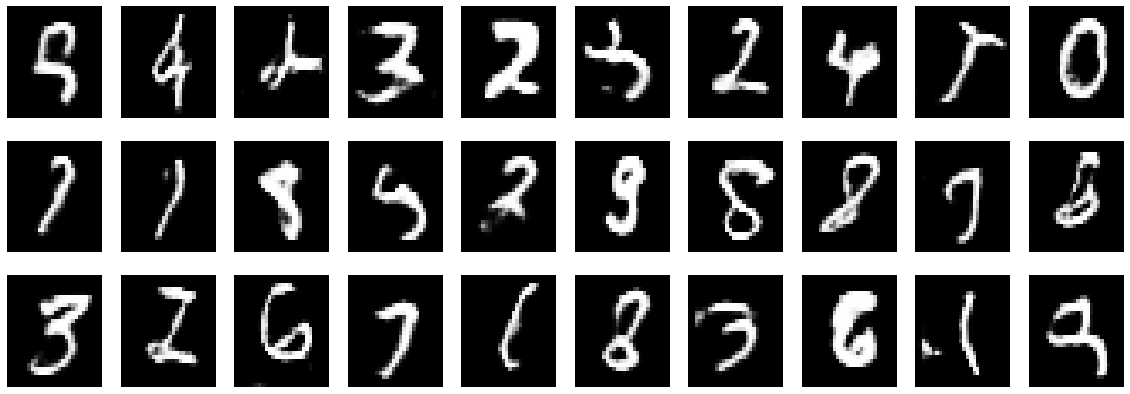

[201/300]	Loss_D = 0.005323	Loss_G = 0.002958	Accuracy = 0.644106	: 100%|██████████| 235/235 [00:21<00:00, 11.10it/s]
[202/300]	Loss_D = 0.005308	Loss_G = 0.002965	Accuracy = 0.643905	: 100%|██████████| 235/235 [00:21<00:00, 11.10it/s]
[203/300]	Loss_D = 0.005287	Loss_G = 0.002990	Accuracy = 0.643706	: 100%|██████████| 235/235 [00:21<00:00, 11.04it/s]
[204/300]	Loss_D = 0.005289	Loss_G = 0.003046	Accuracy = 0.643503	: 100%|██████████| 235/235 [00:21<00:00, 11.15it/s]
[205/300]	Loss_D = 0.005269	Loss_G = 0.003055	Accuracy = 0.643298	: 100%|██████████| 235/235 [00:21<00:00, 11.11it/s]
[206/300]	Loss_D = 0.005296	Loss_G = 0.002983	Accuracy = 0.643095	: 100%|██████████| 235/235 [00:21<00:00, 11.14it/s]
[207/300]	Loss_D = 0.005291	Loss_G = 0.002991	Accuracy = 0.642895	: 100%|██████████| 235/235 [00:21<00:00, 11.15it/s]
[208/300]	Loss_D = 0.005278	Loss_G = 0.003019	Accuracy = 0.642696	: 100%|██████████| 235/235 [00:21<00:00, 11.11it/s]
[209/300]	Loss_D = 0.005313	Loss_G = 0.002950	Accuracy =



Printing generated images after epoch  220 



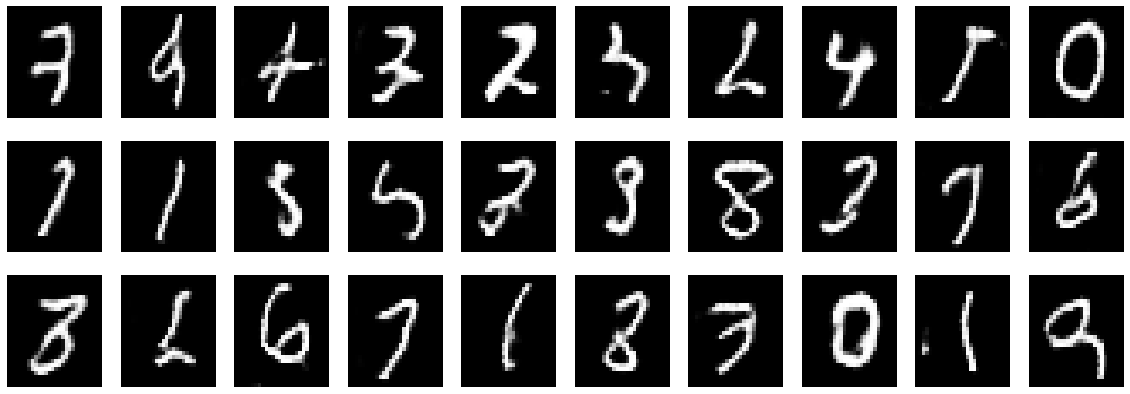

[221/300]	Loss_D = 0.005238	Loss_G = 0.003027	Accuracy = 0.640161	: 100%|██████████| 235/235 [00:21<00:00, 11.05it/s]
[222/300]	Loss_D = 0.005318	Loss_G = 0.003046	Accuracy = 0.639969	: 100%|██████████| 235/235 [00:21<00:00, 11.04it/s]
[223/300]	Loss_D = 0.005314	Loss_G = 0.002941	Accuracy = 0.639780	: 100%|██████████| 235/235 [00:21<00:00, 11.03it/s]
[224/300]	Loss_D = 0.005337	Loss_G = 0.002961	Accuracy = 0.639592	: 100%|██████████| 235/235 [00:21<00:00, 11.01it/s]
[225/300]	Loss_D = 0.005323	Loss_G = 0.002929	Accuracy = 0.639405	: 100%|██████████| 235/235 [00:21<00:00, 11.03it/s]
[226/300]	Loss_D = 0.005322	Loss_G = 0.002910	Accuracy = 0.639220	: 100%|██████████| 235/235 [00:21<00:00, 11.01it/s]
[227/300]	Loss_D = 0.005334	Loss_G = 0.002912	Accuracy = 0.639037	: 100%|██████████| 235/235 [00:21<00:00, 10.97it/s]
[228/300]	Loss_D = 0.005334	Loss_G = 0.002923	Accuracy = 0.638856	: 100%|██████████| 235/235 [00:21<00:00, 10.99it/s]
[229/300]	Loss_D = 0.005354	Loss_G = 0.002951	Accuracy =



Printing generated images after epoch  240 



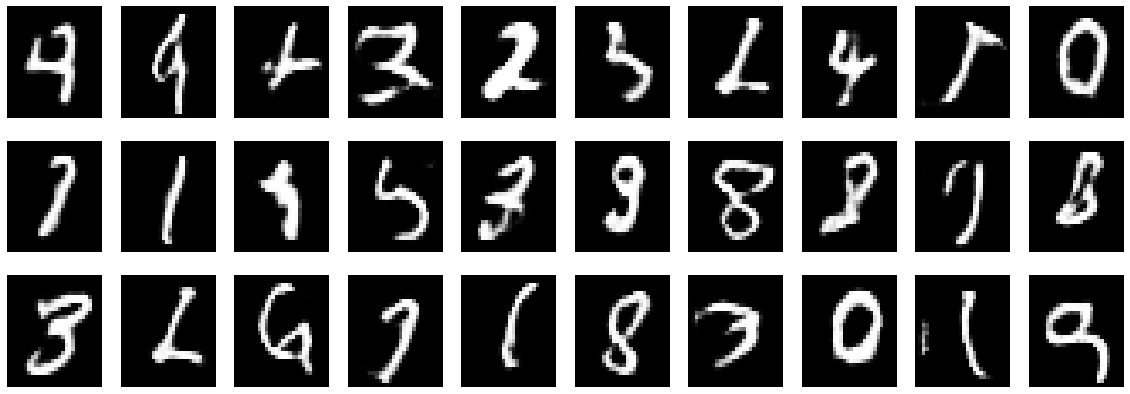

[241/300]	Loss_D = 0.005308	Loss_G = 0.002962	Accuracy = 0.636493	: 100%|██████████| 235/235 [00:21<00:00, 10.90it/s]
[242/300]	Loss_D = 0.005339	Loss_G = 0.002921	Accuracy = 0.636317	: 100%|██████████| 235/235 [00:21<00:00, 10.84it/s]
[243/300]	Loss_D = 0.005281	Loss_G = 0.002969	Accuracy = 0.636141	: 100%|██████████| 235/235 [00:21<00:00, 10.89it/s]
[244/300]	Loss_D = 0.005355	Loss_G = 0.002973	Accuracy = 0.635968	: 100%|██████████| 235/235 [00:21<00:00, 10.92it/s]
[245/300]	Loss_D = 0.005261	Loss_G = 0.002992	Accuracy = 0.635795	: 100%|██████████| 235/235 [00:21<00:00, 10.89it/s]
[246/300]	Loss_D = 0.005371	Loss_G = 0.002947	Accuracy = 0.635624	: 100%|██████████| 235/235 [00:21<00:00, 10.81it/s]
[247/300]	Loss_D = 0.005320	Loss_G = 0.002909	Accuracy = 0.635455	: 100%|██████████| 235/235 [00:21<00:00, 10.82it/s]
[248/300]	Loss_D = 0.005339	Loss_G = 0.002904	Accuracy = 0.635287	: 100%|██████████| 235/235 [00:21<00:00, 10.91it/s]
[249/300]	Loss_D = 0.005338	Loss_G = 0.002924	Accuracy =



Printing generated images after epoch  260 



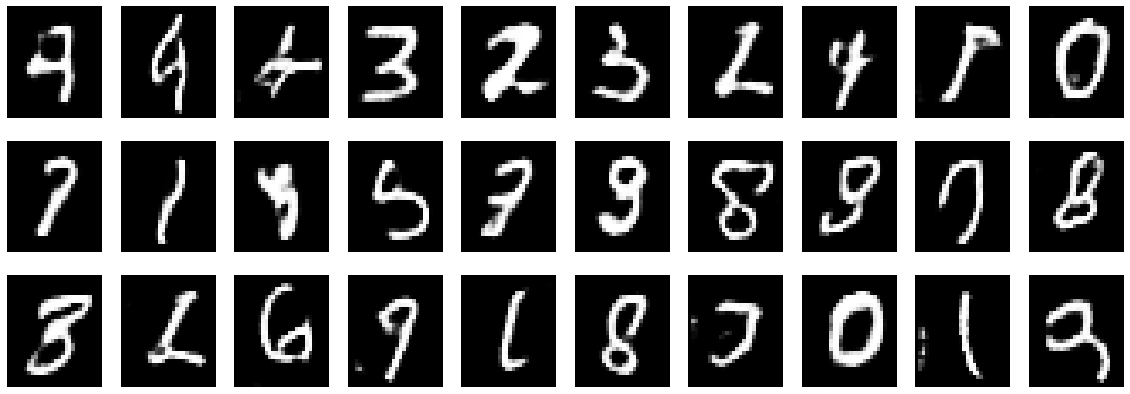

[261/300]	Loss_D = 0.005326	Loss_G = 0.002916	Accuracy = 0.633050	: 100%|██████████| 235/235 [00:21<00:00, 10.72it/s]
[262/300]	Loss_D = 0.005276	Loss_G = 0.002998	Accuracy = 0.632885	: 100%|██████████| 235/235 [00:22<00:00, 10.66it/s]
[263/300]	Loss_D = 0.005306	Loss_G = 0.003008	Accuracy = 0.632721	: 100%|██████████| 235/235 [00:22<00:00, 10.63it/s]
[264/300]	Loss_D = 0.005339	Loss_G = 0.002908	Accuracy = 0.632559	: 100%|██████████| 235/235 [00:22<00:00, 10.65it/s]
[265/300]	Loss_D = 0.005331	Loss_G = 0.002924	Accuracy = 0.632398	: 100%|██████████| 235/235 [00:21<00:00, 10.69it/s]
[266/300]	Loss_D = 0.005305	Loss_G = 0.002929	Accuracy = 0.632238	: 100%|██████████| 235/235 [00:21<00:00, 10.71it/s]
[267/300]	Loss_D = 0.005339	Loss_G = 0.002928	Accuracy = 0.632079	: 100%|██████████| 235/235 [00:21<00:00, 10.77it/s]
[268/300]	Loss_D = 0.005334	Loss_G = 0.002902	Accuracy = 0.631921	: 100%|██████████| 235/235 [00:21<00:00, 10.71it/s]
[269/300]	Loss_D = 0.005325	Loss_G = 0.002914	Accuracy =



Printing generated images after epoch  280 



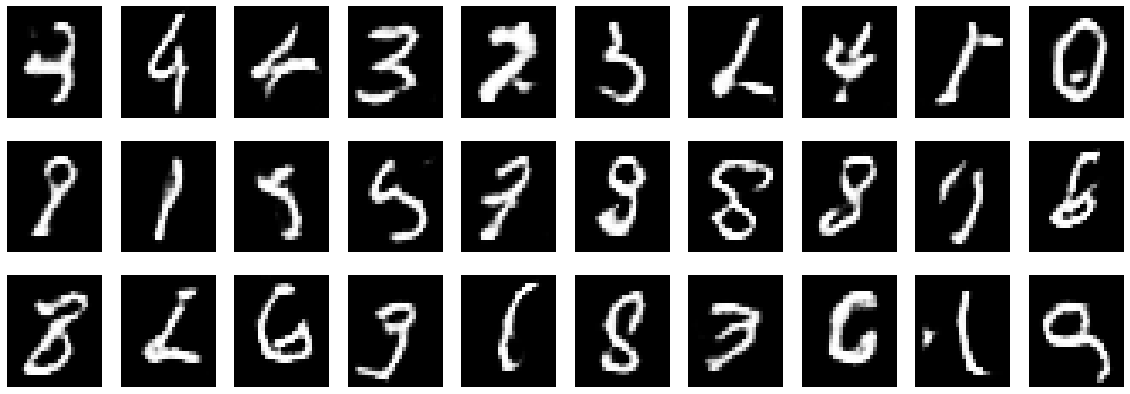

[281/300]	Loss_D = 0.005306	Loss_G = 0.002935	Accuracy = 0.629824	: 100%|██████████| 235/235 [00:21<00:00, 10.71it/s]
[282/300]	Loss_D = 0.005336	Loss_G = 0.002923	Accuracy = 0.629669	: 100%|██████████| 235/235 [00:22<00:00, 10.64it/s]
[283/300]	Loss_D = 0.005333	Loss_G = 0.002934	Accuracy = 0.629514	: 100%|██████████| 235/235 [00:21<00:00, 10.70it/s]
[284/300]	Loss_D = 0.005328	Loss_G = 0.002951	Accuracy = 0.629361	: 100%|██████████| 235/235 [00:22<00:00, 10.68it/s]
[285/300]	Loss_D = 0.005331	Loss_G = 0.002945	Accuracy = 0.629208	: 100%|██████████| 235/235 [00:22<00:00, 10.66it/s]
[286/300]	Loss_D = 0.005319	Loss_G = 0.002963	Accuracy = 0.629057	: 100%|██████████| 235/235 [00:21<00:00, 10.69it/s]
[287/300]	Loss_D = 0.005307	Loss_G = 0.002958	Accuracy = 0.628907	: 100%|██████████| 235/235 [00:22<00:00, 10.64it/s]
[288/300]	Loss_D = 0.005339	Loss_G = 0.002932	Accuracy = 0.628758	: 100%|██████████| 235/235 [00:22<00:00, 10.64it/s]
[289/300]	Loss_D = 0.005323	Loss_G = 0.002895	Accuracy =



Printing generated images after epoch  300 



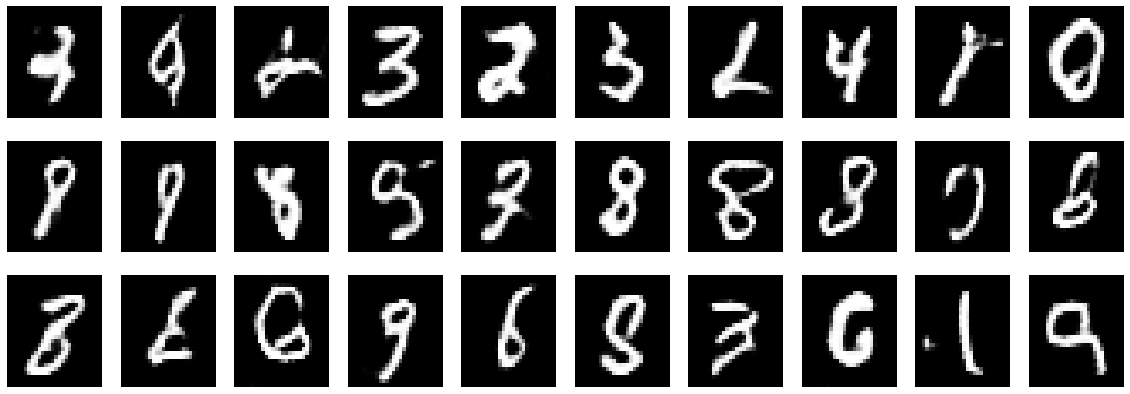

In [14]:
import time
print("Initialising D by first training it on images for 5 epochs : \n")
time.sleep(1)
for epoch in range(EPOCHS_INIT):
    train_bar = tqdm(train_dataset)
    for image_batch in train_bar:
        with tf.GradientTape() as disc_tape:
            noise = tf.random.normal([BATCH_SIZE, noise_dim])
            generated_images = generator(noise, training=False)

            real_out = discriminator(image_batch, training=True)
            fake_out = discriminator(generated_images, training=True)

            disc_loss = discriminator_loss(real_out, fake_out)
            gradients_of_discriminator = disc_tape.gradient(disc_loss, 
                                                discriminator.trainable_variables)
            
            discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
            train_bar.set_description(desc='[%d/%d]    d_loss : %.6f' % (epoch + 1, EPOCHS_INIT, disc_loss))

print("\n\nPrinting generated images before any training \n")
generate_and_save_images(generator, 0, seed)


print("\n\nStart GAN Training : \n")
time.sleep(1)
results = {'g_loss' : [], 'd_loss' : [], 'accuracy' : []}
for epoch in range(1, EPOCHS + 1):

    start = time.time()
    train_bar = tqdm(train_dataset)

    running_results = {'batch_sizes':0, 'g_loss':0, 'd_loss':0, 'accuracy':0}
    for image_batch in train_bar:
        batch_size = len(image_batch)
        real_out, fake_out, gen_loss, disc_loss = train_step(image_batch)

        real_out = tf.squeeze(real_out, axis=-1)
        fake_out = tf.squeeze(fake_out, axis=-1)

        if epoch == 1:
            real_out_global = real_out
            fake_out_global = fake_out
        else:
            real_out_global = tf.concat((real_out, real_out_global), axis=0)
            fake_out_global = tf.concat((fake_out, fake_out_global), axis=0)

        acc = cal_accuracy(real_out_global, fake_out_global)

        running_results['accuracy'] = acc
        running_results['g_loss'] += gen_loss
        running_results['d_loss'] += disc_loss
        running_results['batch_sizes'] += batch_size


        train_bar.set_description(desc='[%d/%d]\tLoss_D = %.6f\tLoss_G = %.6f\tAccuracy = %.6f\t' % (
            epoch,
            EPOCHS,
            running_results['d_loss']/running_results['batch_sizes'],
            running_results['g_loss']/running_results['batch_sizes'],
            running_results['accuracy']
        ))

    results['g_loss'].append(running_results['g_loss'])
    results['d_loss'].append(running_results['d_loss'])
    results['accuracy'].append(running_results['accuracy'])

    

    if epoch % 20 == 0:
        print("\n\nPrinting generated images after epoch ", epoch, "\n")
        generate_and_save_images(generator, epoch, seed)



NOTE : THE LOSS IS TOTAL LOSS ACROSS ALL DATA POINTS. IT IS NOT NORMALISED BY NUMBER OF DATA POINTS




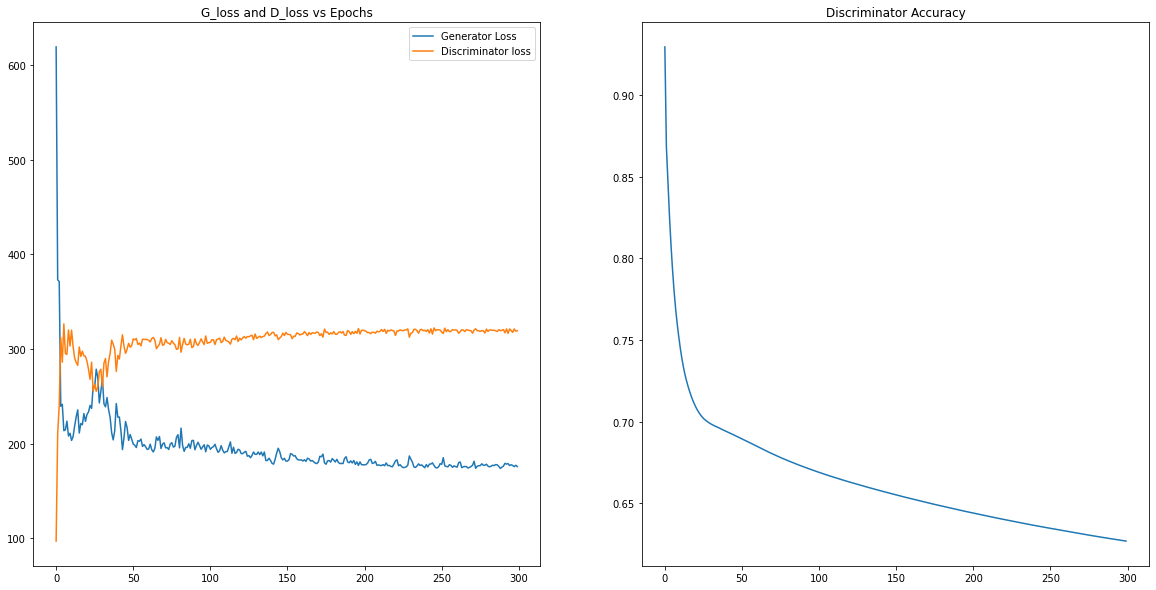

In [206]:
print("\nNOTE : THE LOSS IS TOTAL LOSS ACROSS ALL DATA POINTS. IT IS NOT NORMALISED BY NUMBER OF DATA POINTS\n\n")
plt.figure(figsize=(20, 10))
plt.subplot(1, 2, 1)
plt.plot(results['g_loss'])
plt.plot(results['d_loss'])
plt.title("G_loss and D_loss vs Epochs")
plt.legend(["Generator Loss", "Discriminator loss"])
plt.subplot(1, 2, 2)
plt.plot(results['accuracy'])
plt.title("Discriminator Accuracy")
plt.show()

## **Comments and Analysis**

* Initially, the discriminator was trained to classify between original images and generated images for 5 epochs. (Strong discriminator).

* Then during each epoch, we alternatively train generator and discrimnator with following objectives. 


1.   **Discriminator objective :** Classify each correct image($x$) and generated mage (image generated from noise $z$) correctly. 
2.   **Generator objective :** Generate an image such that it is not possible for discriminator to correctly classify the generated image as generated image. 

As we train the model, we observe that the generator consistently try to generate images in order to fool the discriminator. 

* The fall in discriminator accuracy proves that the generated images are constantly getting better and better plus more like original images.





## **Images before any training**

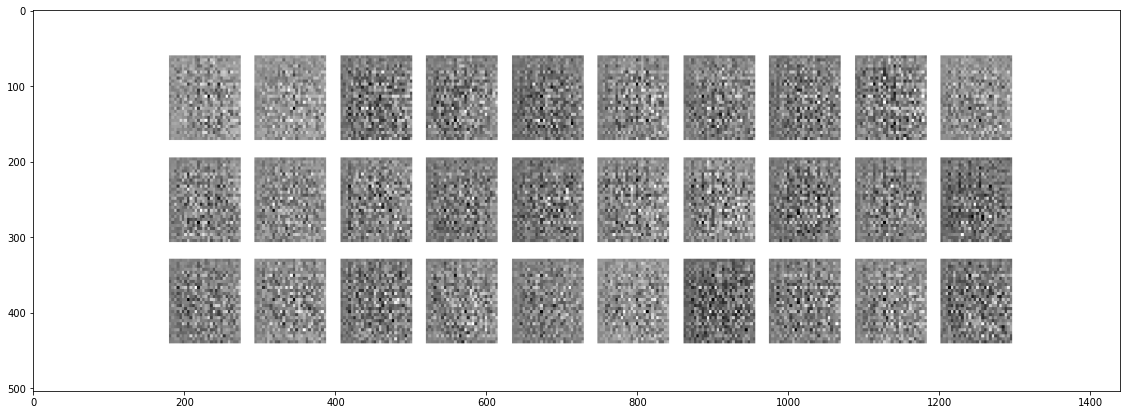

In [26]:
plt.figure(figsize=(20, 7))
img = plt.imread('/content/images/image_at_epoch_0000.png')
plt.imshow(img, cmap='gray')
plt.show()

## **Images mid-way on training (at epoch = 60)**

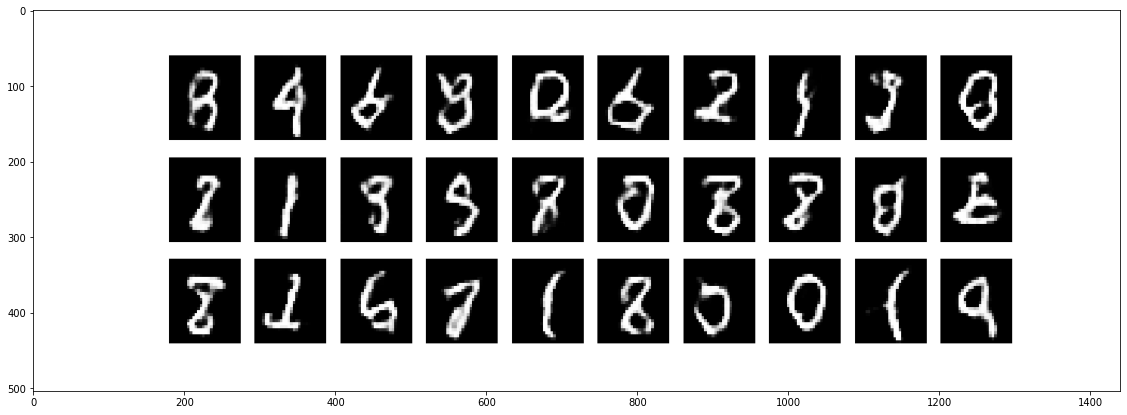

In [27]:
plt.figure(figsize=(20, 7))
img = plt.imread('/content/images/image_at_epoch_0060.png')
plt.imshow(img, cmap='gray')
plt.show()

## **Images mid-way on training (at epoch = 120)**

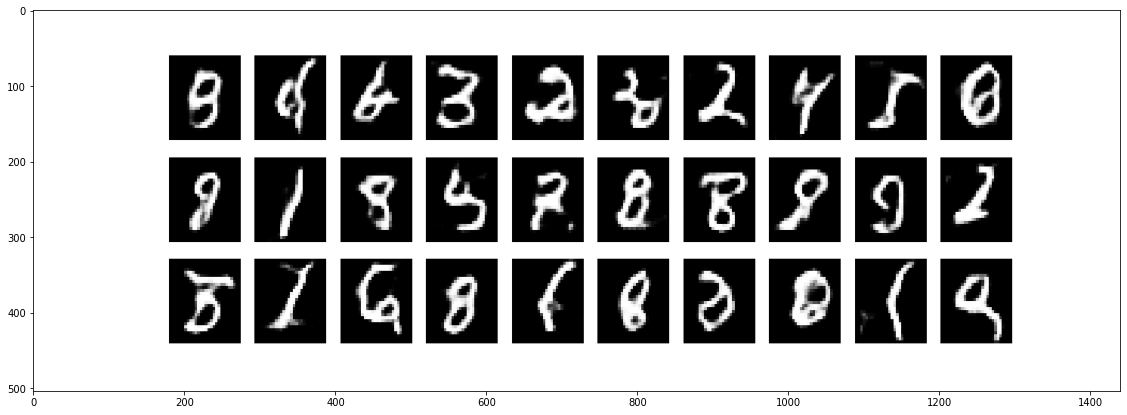

In [28]:
plt.figure(figsize=(20, 7))
img = plt.imread('/content/images/image_at_epoch_0120.png')
plt.imshow(img, cmap='gray')
plt.show()

## **Images middle on training (at epoch = 160)**

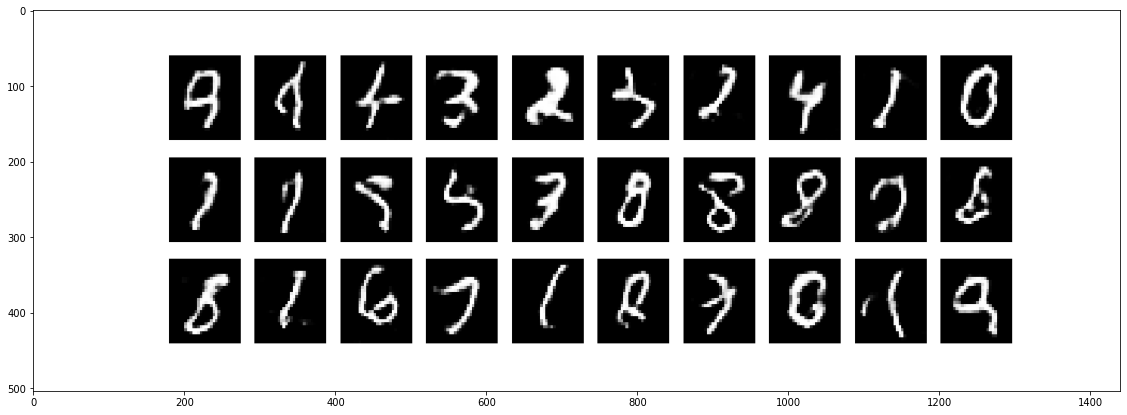

In [29]:
plt.figure(figsize=(20, 7))
img = plt.imread('/content/images/image_at_epoch_0160.png')
plt.imshow(img, cmap='gray')
plt.show()

## **Images mid-way on training (at epoch = 180)**

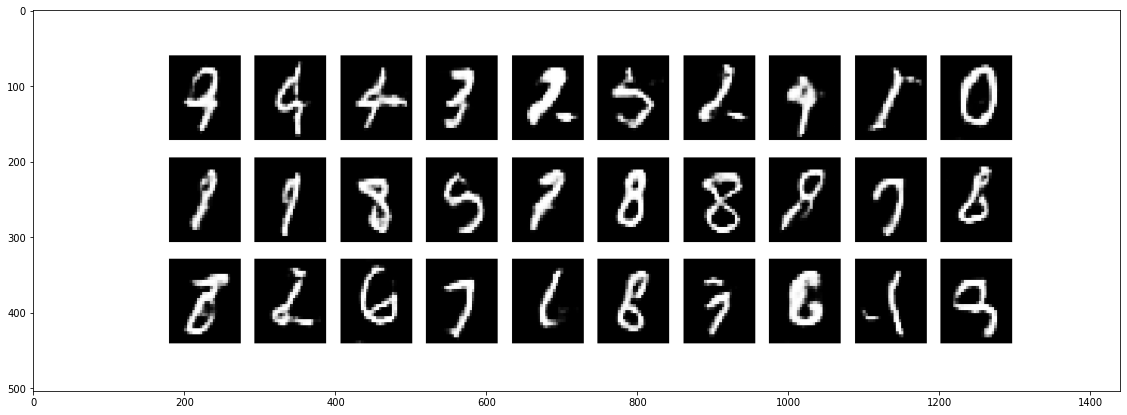

In [30]:
plt.figure(figsize=(20, 7))
img = plt.imread('/content/images/image_at_epoch_0180.png')
plt.imshow(img, cmap='gray')
plt.show()

## **Images mid-way on training (at epoch = 240)**

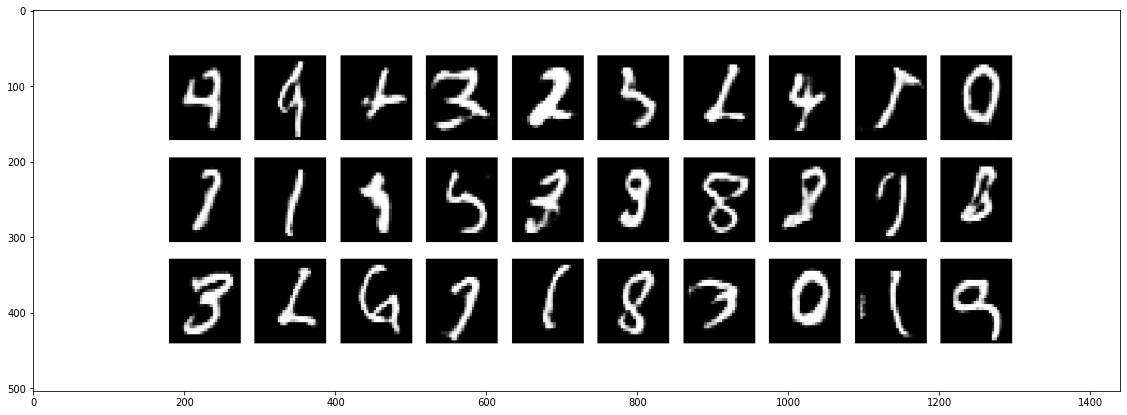

In [31]:
plt.figure(figsize=(20, 7))
img = plt.imread('/content/images/image_at_epoch_0240.png')
plt.imshow(img, cmap='gray')
plt.show()

## **Images at end of training (After 300 epochs)**



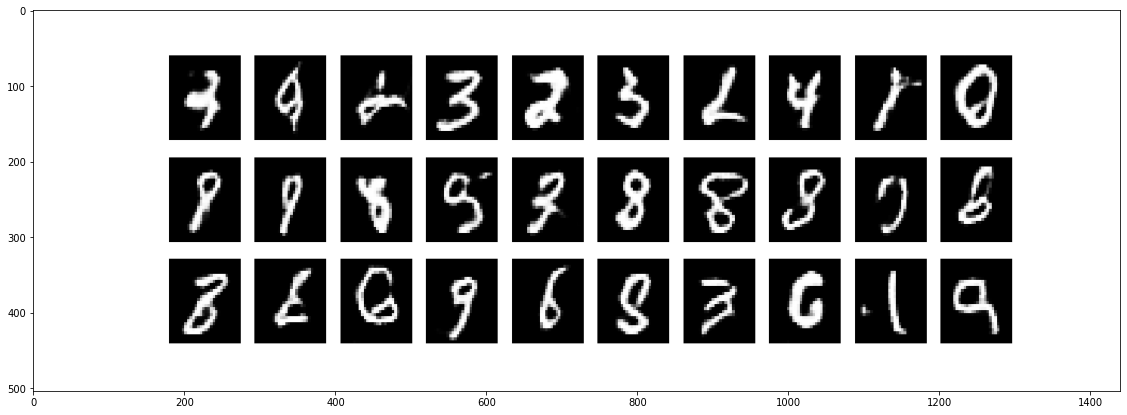

In [33]:
plt.figure(figsize=(20, 7))
img = plt.imread('/content/images/image_at_epoch_0300.png')
plt.imshow(img, cmap='gray')
plt.show()

## **Comments and Analysis**

* Initially we get a noisy and non interpretable output, since initially the generator is not trained and it generates random images. 

* We observe that, over time, generated images are more and more closer to original images. 

# **Task 2 :**
**Sample two images from GAN of different classes. Interpolate between two digits in the
latent space. Use 8 steps, so there will be 10 images (including the two selected before).
Display the results.**

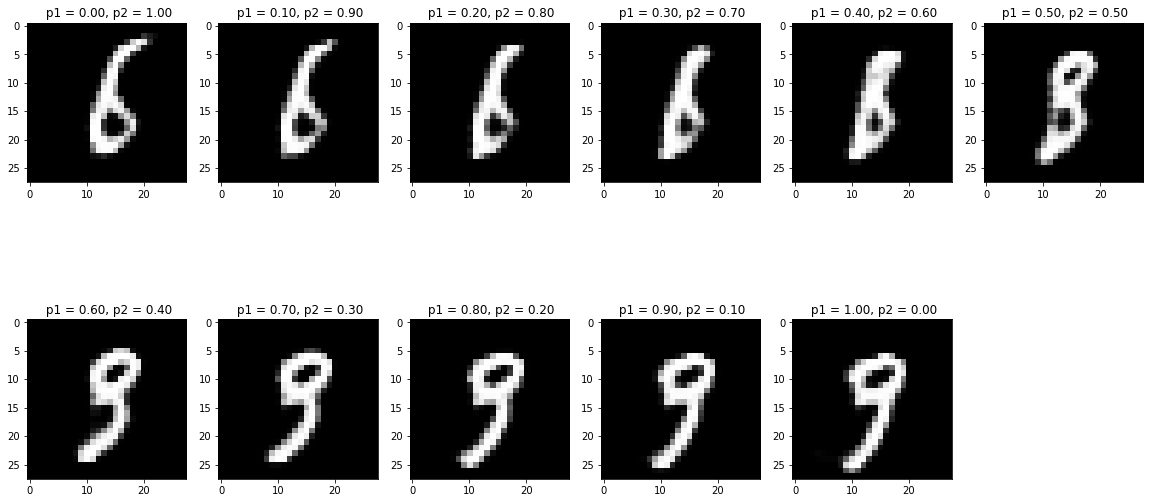

In [69]:
s1 = seed[23, :]
s2 = seed[24, :]

latent_s1 = tf.expand_dims(s1, 0)
latent_s2 = tf.expand_dims(s2, 0)

images = []
p = np.arange(0.0, 1.1, 0.1)

plt.figure(figsize=(20, 10))
idx=1
for prob in p:
    interpolated_latent_vector = prob * latent_s1 + (1-prob)*latent_s2
    generated_image = generator.predict(interpolated_latent_vector)
    plt.subplot(2,6,idx)
    plt.imshow(generated_image[0,:,:,0], cmap='gray')
    plt.title(" p1 = %.2f, p2 = %.2f" %(prob, 1-prob))
    idx+=1
plt.show()

## **Comments and Analysis**

* I sampled two latent vectors from seed. Our generator network generated two images of classes "six" and "nine" respectively. 

* We observe the effect of how the generated image changes when we interpolate the latent vector between latent vectors of two classes. 

### **Analysis** 

* We observe that the distribution of noise is being mapped to distribution of original images. How? As we increase weight of latent vector corresponding to image class 9, we also observe that the generated image accordingly shift towards nine. 

* Observing image number 6, which looks like 8, we make following observation : The latent vector of this image was average of latent vectors of 6 and 9. In this image, we observe image like 8. The upper circle is contribution of 6, while lower one is contribution of 9. This is a good observation that the latent vectors of 8 would be around the average of latent vectors of 6 and 9. 

* Generator has successfully mapped the noisy random gaussian distribution to the a very good approximate distribution of original data points. Since the interpolation in latent space also shows the similar effect in generated image space. 

# **Task 3**

**Data augmentation using GAN**

## **Generate and visualise fake images**

* I generate same number of fake images as that of training images. So in total, after augmentation, there will be 120000 images in training dataset.

In [155]:
def generate_n_images(generator, n):
    noise = tf.random.normal([n, noise_dim])

    generated = []
    for i in range(n//1000):
        generated.append(generator(noise[i*1000 : (i+1)*1000]))
    generated_samples = tf.concat(generated, axis=0)
    return generated_samples.numpy()

In [156]:
fake_train_images = generate_n_images(generator, 60000)

In [157]:
fake_train_images.shape

(60000, 28, 28, 1)

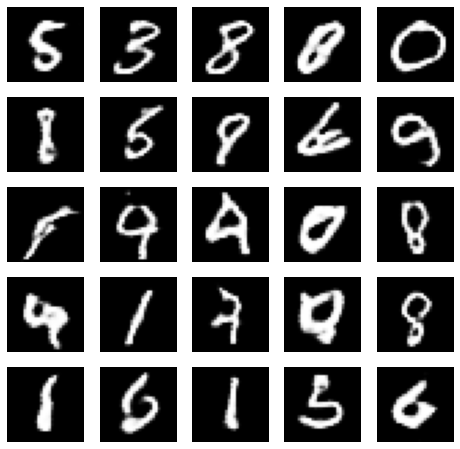

In [158]:
plt.figure(figsize=(8, 8))
for i in range(25):
	plt.subplot(5, 5, 1 + i)
	plt.axis('off')
	plt.imshow(fake_train_images[i,:,:,0], cmap='gray', aspect='auto')
plt.show()

In [159]:
(train_images, _), (test_images, _) = tf.keras.datasets.mnist.load_data() 


train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
train_images = (train_images - 127.5) / 127.5

test_images = test_images.reshape(test_images.shape[0], 28, 28, 1).astype('float32')
test_images = (test_images - 127.5) / 127.5 

BUFFER_SIZE = 120000
BATCH_SIZE = 256

train_images_augmented = np.vstack([train_images, fake_train_images])
train_dataset_augmented = tf.data.Dataset.from_tensor_slices(train_images_augmented).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [160]:
train_images_augmented.shape, train_images.shape

((120000, 28, 28, 1), (60000, 28, 28, 1))

## **Define a denoising autoencoder**

In [162]:
def make_denoising_autoencoder():
    model = Sequential()

    # Encoder part
    model.add(Conv2D(64, (3, 3), padding='same', input_shape=(28, 28, 1), use_bias=False))
    model.add(BatchNormalization())
    model.add(LeakyReLU())
    model.add(Dropout(0.3))

    model.add(MaxPool2D())

    model.add(Conv2D(128, (3, 3), padding='same', input_shape=(28, 28, 1), use_bias=False))
    model.add(BatchNormalization())
    model.add(LeakyReLU())
    model.add(Dropout(0.3))

    model.add(MaxPool2D())

    # Latent vector of size 256
    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(Dense(7*7*128, activation='relu'))

    
    # Decoder part
    model.add(Reshape((7, 7, 128)))
    model.add(UpSampling2D())
    
    model.add(Conv2DTranspose(64, (3, 3), padding='same', use_bias=False))
    model.add(BatchNormalization())
    model.add(LeakyReLU())
    model.add(Dropout(0.3))


    model.add(UpSampling2D())

    model.add(Conv2DTranspose(1, (3, 3), padding='same', activation = 'tanh', use_bias=False))

    return model

In [163]:
model_original = make_denoising_autoencoder()
model_augmented = tf.keras.models.clone_model(model_original)
model_original.compile(optimizer='adam', loss='mse', metrics=['mse'])
model_augmented.compile(optimizer='adam', loss='mse', metrics=['mse'])

In [164]:
model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_14 (Conv2D)           (None, 28, 28, 64)        576       
_________________________________________________________________
batch_normalization_17 (Batc (None, 28, 28, 64)        256       
_________________________________________________________________
leaky_re_lu_19 (LeakyReLU)   (None, 28, 28, 64)        0         
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 14, 14, 128)       73728     
_________________________________________________________________
batch_normalization_18 (Batc (None, 14, 14, 128)       512       
_________________________________________________________________
leaky_re_lu_20 (LeakyReLU)   (None, 14, 14, 128)      

## **Add noise to datasets**

In [165]:
train_images_noisy = train_images  + tf.random.normal(train_images.shape, -0.2, 1.0)
train_images_augmented_noisy = train_images_augmented + tf.random.normal(train_images_augmented.shape, -0.2, 1.0)
test_images_noisy = test_images + tf.random.normal(test_images.shape, -0.2, 1.0)

train_images_noisy = train_images_noisy.numpy()
train_images_augmented_noisy = train_images_augmented_noisy.numpy()
test_images_noisy = test_images_noisy.numpy()

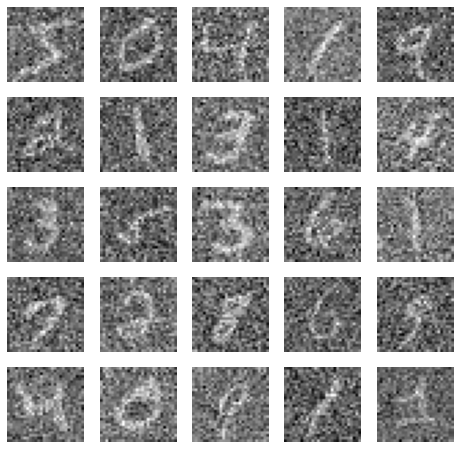

In [166]:
plt.figure(figsize=(8, 8))
for i in range(25):
	plt.subplot(5, 5, 1 + i)
	plt.axis('off')
	plt.imshow(train_images_noisy[i,:,:,0], cmap='gray', aspect='auto')
plt.show()

## **Train two models, one without data of GAN and one with data augmented from GAN**

In [167]:
print("Training model without augmented data")
history_original = model_original.fit(train_images_noisy, train_images, batch_size=512, epochs=40, validation_data=(test_images_noisy, test_images))

Training model without augmented data
Epoch 1/40
118/118 [==============================] - 12s 102ms/step - loss: 0.4010 - mse: 0.4010 - val_loss: 0.4025 - val_mse: 0.4025
Epoch 2/40
118/118 [==============================] - 12s 100ms/step - loss: 0.1508 - mse: 0.1508 - val_loss: 0.4194 - val_mse: 0.4194
Epoch 3/40
118/118 [==============================] - 12s 101ms/step - loss: 0.0919 - mse: 0.0919 - val_loss: 0.3662 - val_mse: 0.3662
Epoch 4/40
118/118 [==============================] - 12s 101ms/step - loss: 0.0734 - mse: 0.0734 - val_loss: 0.2535 - val_mse: 0.2535
Epoch 5/40
118/118 [==============================] - 12s 101ms/step - loss: 0.0646 - mse: 0.0646 - val_loss: 0.1393 - val_mse: 0.1393
Epoch 6/40
118/118 [==============================] - 12s 101ms/step - loss: 0.0597 - mse: 0.0597 - val_loss: 0.0995 - val_mse: 0.0995
Epoch 7/40
118/118 [==============================] - 12s 101ms/step - loss: 0.0570 - mse: 0.0570 - val_loss: 0.0805 - val_mse: 0.0805
Epoch 8/40
118/11

In [169]:
print("Training model with augmented data")
history_augmented = model_augmented.fit(train_images_augmented_noisy, train_images_augmented, batch_size=512, epochs=40, validation_data=(test_images_noisy, test_images))

Training model with augmented data
Epoch 1/40
235/235 [==============================] - 24s 100ms/step - loss: 0.2505 - mse: 0.2505 - val_loss: 0.4170 - val_mse: 0.4170
Epoch 2/40
235/235 [==============================] - 23s 99ms/step - loss: 0.0811 - mse: 0.0811 - val_loss: 0.2486 - val_mse: 0.2486
Epoch 3/40
235/235 [==============================] - 23s 99ms/step - loss: 0.0624 - mse: 0.0624 - val_loss: 0.1108 - val_mse: 0.1108
Epoch 4/40
235/235 [==============================] - 23s 100ms/step - loss: 0.0560 - mse: 0.0560 - val_loss: 0.0812 - val_mse: 0.0812
Epoch 5/40
235/235 [==============================] - 23s 100ms/step - loss: 0.0524 - mse: 0.0524 - val_loss: 0.0670 - val_mse: 0.0670
Epoch 6/40
235/235 [==============================] - 23s 100ms/step - loss: 0.0501 - mse: 0.0501 - val_loss: 0.0650 - val_mse: 0.0650
Epoch 7/40
235/235 [==============================] - 24s 100ms/step - loss: 0.0485 - mse: 0.0485 - val_loss: 0.0603 - val_mse: 0.0603
Epoch 8/40
235/235 [==

## **Visualisation and comparison**

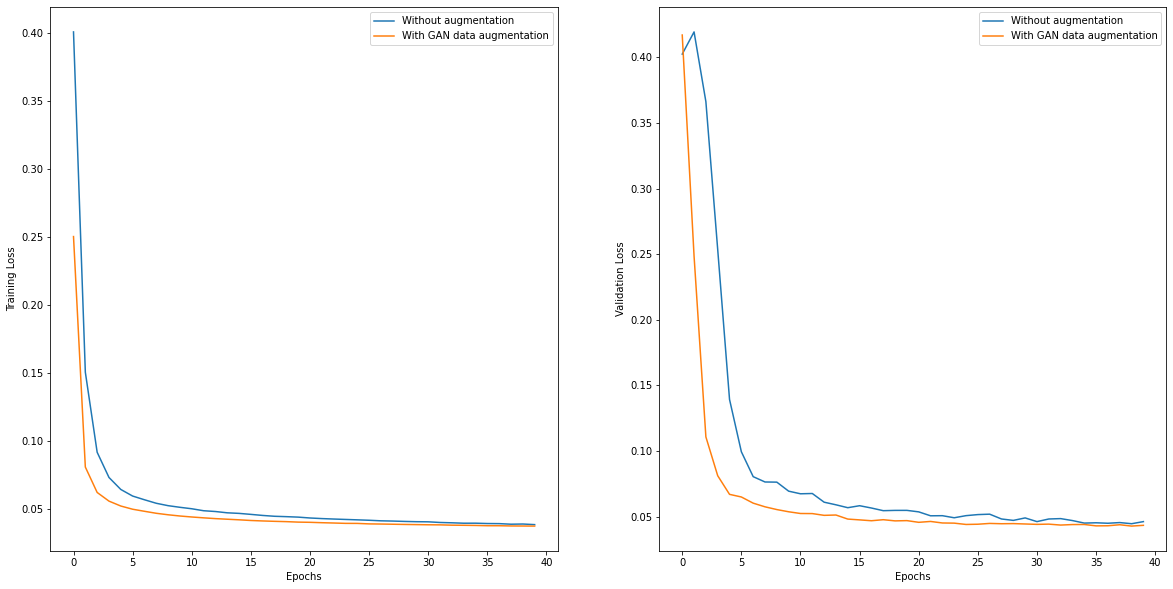

In [183]:
plt.figure(figsize=(20, 10))
plt.subplot(1, 2, 1)
plt.plot(history_original.history['loss'])
plt.plot(history_augmented.history['loss'])
plt.xlabel("Epochs")
plt.ylabel("Training Loss")
plt.legend(["Without augmentation", "With GAN data augmentation"])
plt.subplot(1, 2, 2)
plt.plot(history_original.history['val_loss'])
plt.plot(history_augmented.history['val_loss'])
plt.xlabel("Epochs")
plt.ylabel("Validation Loss")
plt.legend(["Without augmentation", "With GAN data augmentation"])
plt.show()

## **Comments and Analysis**

* In this case, as we can see, data augmentation using GAN gives more better validation set MSE than the one without augmentation. 
* This shows that, the data that we augmented is better approximation to original data distribution. 
* The model with data augmentation generalises well on test set. 


* **Note :** However, the performance also depends on the amount of data added, how well the generator has approximated the original distribution of the training data. If the approximation is not good and the amount is also more, then we expect poor performance in data augmentation case. In this case, we can consider the poorly generated images as a noisy samples. So, these noisy samples degrades the performance of overall model. 

* However in this case, we can clearly see that the amount of data added is very huge, but still we get good performance. This means that the distribution of generated points is good approximation of original distribution. 

## **Visualising test set images**

Original Test set images


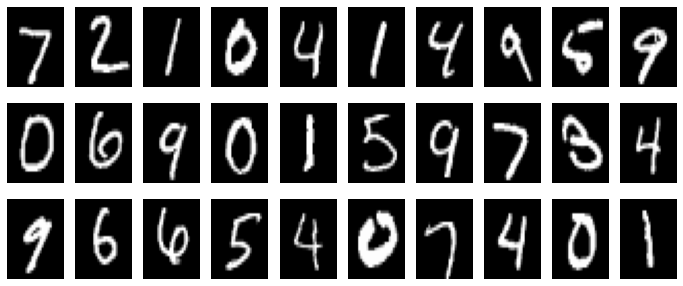



Noisy Test set images


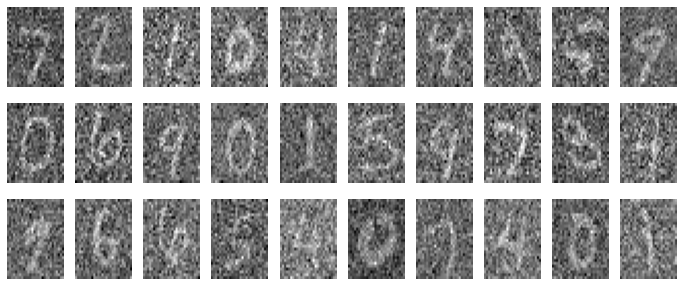



Model 1 (without data augmentation) denoised images


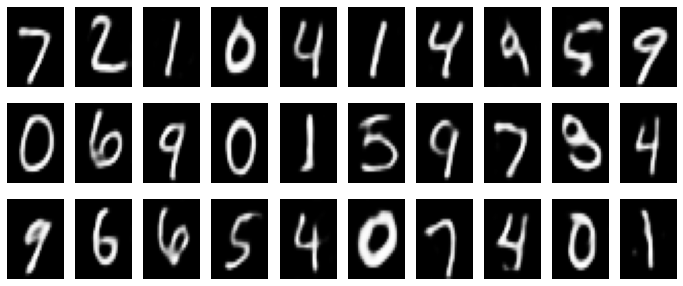



Model 2 (with data augmentation) denoised images


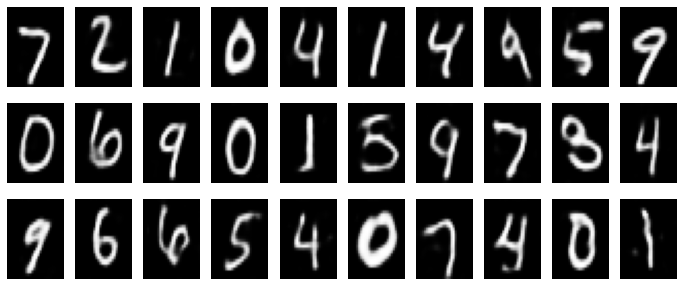

In [196]:
print("Original Test set images")
plt.figure(figsize=(12, 5))
for i in range(30):
	plt.subplot(3, 10, 1 + i)
	plt.axis('off')
	plt.imshow(test_images[i,:,:,0], cmap='gray', aspect='auto')
plt.show()

print("\n\nNoisy Test set images")
plt.figure(figsize=(12, 5))
for i in range(30):
	plt.subplot(3, 10, 1 + i)
	plt.axis('off')
	plt.imshow(test_images_noisy[i,:,:,0], cmap='gray', aspect='auto')
plt.show()

print("\n\nModel 1 (without data augmentation) denoised images")
denoised = model_original(test_images_noisy[:30, :, :, :], training=False)
plt.figure(figsize=(12, 5))
for i in range(30):
	plt.subplot(3, 10, 1 + i)
	plt.axis('off')
	plt.imshow(denoised[i,:,:,0], cmap='gray', aspect='auto')
plt.show()

print("\n\nModel 2 (with data augmentation) denoised images")
denoised = model_augmented(test_images_noisy[:30, :, :, :], training=False)
plt.figure(figsize=(12, 5))
for i in range(30):
	plt.subplot(3, 10, 1 + i)
	plt.axis('off')
	plt.imshow(denoised[i,:,:,0], cmap='gray', aspect='auto')
plt.show()

We here verify that, indeed both of our models are trained properly, and both of them are working as expected for image denoising. 